<a href="https://colab.research.google.com/github/YogitaaSharma/-Detecting-lane-lines/blob/main/GenerativeTestTask_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this test task we assume the following setup:
1. We have a small number of samples we actually want to generate;
2. We have some more samples that are closely related to the samples we want to generate;
3. And some more samples, that are completely unrelated structurally but share the same imaging modality.

For the sake of simplicity, we will use FashionMNIST dataset as an example. We want to generate images of sandals, having only 100 training examples, having 6k training images of ankle boots and sneakers, and more images of other wearables. We assume a simple task of classification as the downstream analysis task. We will classify all shoes into three classes (ankle, sneaker and sandal). As a baseline solution of this task, we use the simple oversampling of the data before the classifier training.

We provide you with our default solution for the generative oversampling, where we train a conditional VAE having only images of shoes in general as a dataset (see code). The results are of course not optimal and your task is to try to improve them. We do not expect you to provide a perfect solution, the aims are:
1. Implementation of a better solution than ours by simple enhancements (the aim is to show that you can work with and quickly optimize neural networks, the aim is _not_ a perfect solution);
2. Trying new things beyond the obvious enhancmenets and to reason about the outcome.

More detailed:
1. We are not interested in longer trainings or additional datasets search, the aim is to simply modify the training procedure, model architecture, loss, data sampling, whatever you choose. Here are some links for inspiration, but feel free to find your own, or focus on stacking simple techniques you already know well.
  - https://github.com/HongleiXie/demo-CVAE
  - https://github.com/GZWQ/Awesome-Long-Tailed
  - https://www.ijcai.org/proceedings/2019/0334.pdf
2. The implementation should be such that a technically skilled person can read through your code (a bit of a documentation and structure is expected).
3. Write a short summary on what measure you took, what were the outcomes, what are the reasons behind those outcomes (a bad result with a good reasoning may save a lot of time in future research). Also, if you have some ideas which you planned to implement but do not have the time for anymore, just write them down as bulletpoints, they will be a big plus and we can then discuss them.

## Imports

**General Problem:**
FashionMNIST, as a dummy dataset, is inherently balanced, with each class containing an equal number of examples. However, in our specific task, we've introduced an imbalance, and this imbalance is problematic for the following reasons:
Bias: A deep learning model trained on imbalanced data tends to develop a bias towards the class with more samples.
Inaccuracy: The model might default to predicting the majority class, leading to a superficial and ineffective solution.

**Tools and Platforms:**
For this task, we'll leverage the power of deep learning frameworks, which are essential tools designed to facilitate the creation, training, and evaluation of intricate neural networks. While there are multiple options like TensorFlow and Keras, our choice for this study is PyTorch, given its flexibility and robustness. All computations and model training will be executed on Google Colab, a cloud-based platform that offers free access to GPUs, making deep learning tasks more efficient.

**Objective:**
Our primary aim in this study is to generate equal sets of images across three distinct categories from the FashionMNIST dataset: sandals, ankle boots, and sneakers. The challenge stems from the fact that the number of training samples for each class differs significantly in our problem.
Sandals: Only 100 training examples.
Ankle Boots & Sneakers: 6,000 training images each.



**Importing important Libraries**

In [264]:
!pip install  pytorch_lightning

In [265]:
import torchvision
import torch
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline
from tqdm.auto import tqdm
import math
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import pytorch_lightning as pl

In [266]:
torch.cuda.is_available()

True

**General flow of Deep learning (CRISP-DM)**

We will follow the CRISP_DM flow to complete our task.

**Understanding Business Objective: **
We aim to comprehend the client's goals and ascertain how our deep learning model can address them.
Possible Scenario: In a hotel setting, the management seeks to quantify the daily usage of different types of footwear by guests. This information will aid in designing a shoe rack that optimizes size and space efficiency.



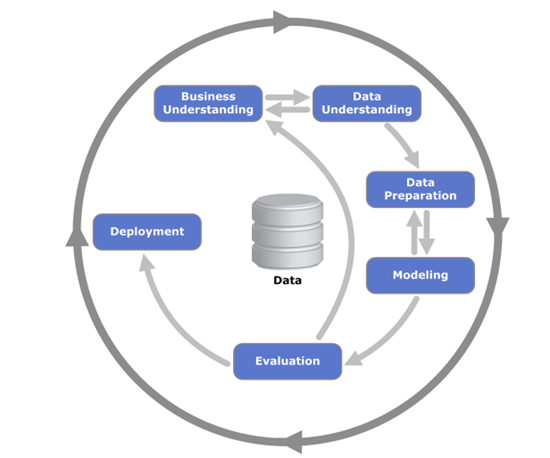

Data Understanding : We are working with Fashion MNIST dataset. It includes 10 classes with 6k images given for each , therefore it is balanced inherently.


**Loading the dataset **

In [267]:
raw_fmnist = torchvision.datasets.FashionMNIST('FashionMNIST', download=True)

In [268]:
raw_fmnist.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

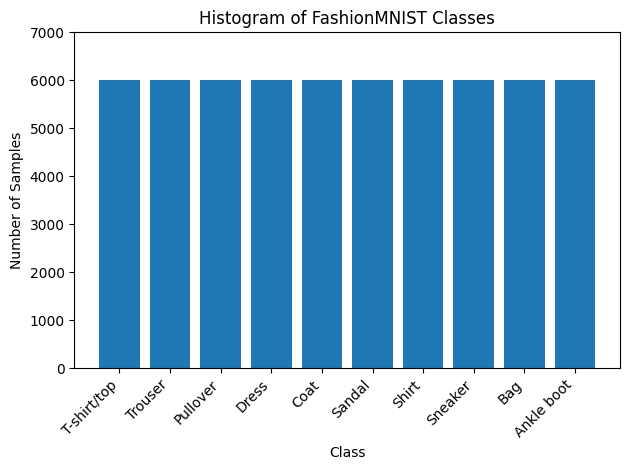

In [269]:
# Get the labels
labels = raw_fmnist.targets.numpy()

# Count the occurrences of each class
class_counts = Counter(labels)

# Find the maximum class count
max_count = max(class_counts.values())

# Plot the histogram
plt.bar(range(10), class_counts.values())
plt.xticks(range(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of FashionMNIST Classes')
plt.ylim([0, max_count + 1000])  # Set the y-axis limit
plt.tight_layout()  # Adjust the layout for better visualization
plt.show()

**Visualizing Sample Images from Selected Classes**

In this section, we aim to visually inspect sample images from three specific classes (5, 7, and 9) of the Fashion MNIST dataset.

Data Extraction

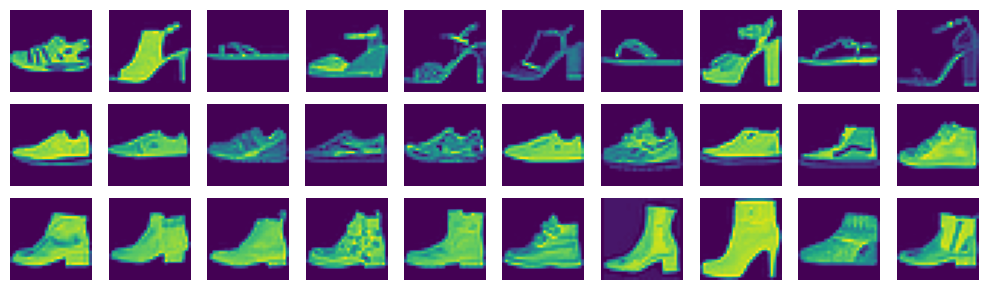

In [270]:
# class labels to visualize
class_labels = [5, 7, 9]

# figure with subplots
fig, axes = plt.subplots(nrows=len(class_labels), ncols=10, figsize=(10, len(class_labels)))

# Iterating over the class labels
for row, label in enumerate(class_labels):

    indices = np.where(raw_fmnist.targets == label)[0]

    selected_indices = np.random.choice(indices, size=10, replace=False)

    for col, index in enumerate(selected_indices):
        image = raw_fmnist.data[index]
        ax = axes[row, col]
        ax.imshow(image)
        ax.axis('off')


row_titles = ['Class 5', 'Class 7', 'Class 9']
for i, row_title in enumerate(row_titles):
    axes[i, 0].set_ylabel(row_title, rotation=90, fontsize=12)


plt.tight_layout()


plt.show()


**Creating Imbalanced Datasets for Training, Validation, and Testing**

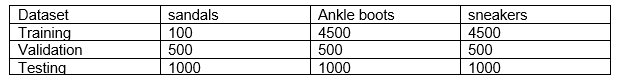

In [271]:
# Preparing Imbalance dataset.

indexes_train = np.concatenate([np.where(raw_fmnist.targets==5)[0][:100],
                               np.where(raw_fmnist.targets==7)[0][:4500],
                                np.where(raw_fmnist.targets==9)[0][:4500]])
indexes_valid = np.concatenate([np.where(raw_fmnist.targets==5)[0][-1500:-1000],
                                np.where(raw_fmnist.targets==7)[0][-1500:-1000],
                                np.where(raw_fmnist.targets==9)[0][-1500:-1000]])
indexes_test = np.concatenate([np.where(raw_fmnist.targets==5)[0][-1000:],
                                np.where(raw_fmnist.targets==7)[0][-1000:],
                                np.where(raw_fmnist.targets==9)[0][-1000:]])

**Visualizing the Distribution of Samples Across Classes**

In [272]:
def plot_histogram(class_counts, class_labels, dataset_name):
    plt.bar(range(len(class_labels)), class_counts)
    plt.xticks(range(len(class_labels)), class_labels, rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'Histogram of FashionMNIST Classes ({dataset_name} Data)')
    plt.tight_layout()
    plt.show()


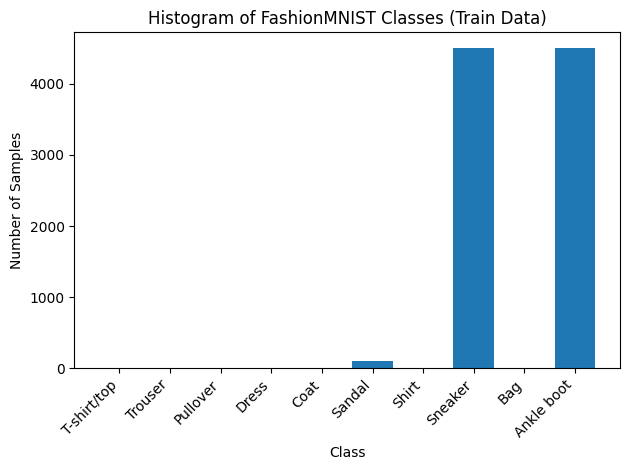

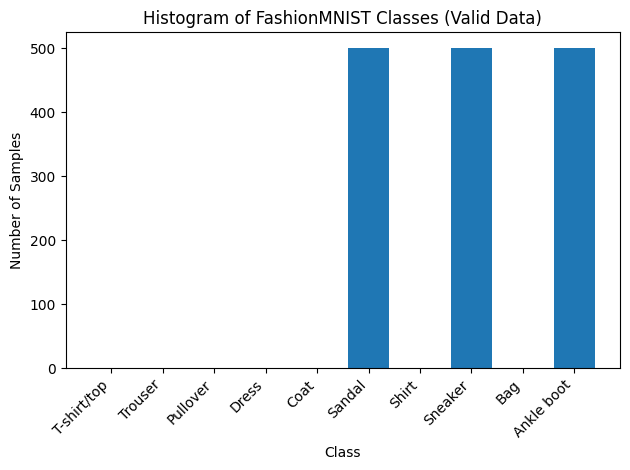

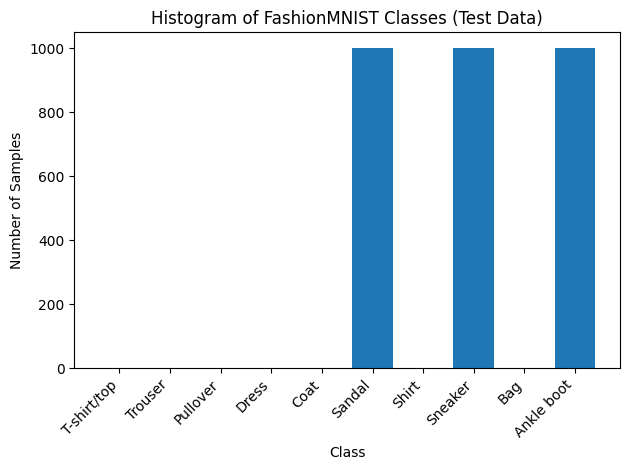

In [273]:
# Visualising the imbalanced and extracted dataset dataset

# class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_labels = raw_fmnist.targets.numpy()[indexes_train]
valid_labels = raw_fmnist.targets.numpy()[indexes_valid]
test_labels = raw_fmnist.targets.numpy()[indexes_test]

train_class_counts = np.bincount(train_labels, minlength=10)
valid_class_counts = np.bincount(valid_labels, minlength=10)
test_class_counts = np.bincount(test_labels, minlength=10)

plot_histogram(train_class_counts, class_labels, 'Train')

plot_histogram(valid_class_counts, class_labels, 'Valid')

plot_histogram(test_class_counts, class_labels, 'Test')


**Approach 1:**

**Upsampling Class 5 for a Balanced Training Dataset**

Given the imbalances detected in our training data, where class 5 had a significantly lower representation compared to classes 7 and 9, we proceed to implement an upsampling technique to balance out the number of samples across these classes. By doing this, we aim to prevent our model from being biased towards the over-represented classes and neglecting the under-represented class.

Upsampling:

The initial 100 samples of class 5 are replicated 45 times, resulting in a total of 4500 samples (100 x 45 = 4500). This way, class 5's representation is increased to match that of classes 7 and 9.

Note: This method involves direct repetition of samples, which might not be the most robust and also result in bias towards majority class.

**Data Preparation**

In [274]:
# Upsampling data for class 5 and preparing a final dataset.

indexes_train_upsampled = np.concatenate([np.where(raw_fmnist.targets==5)[0][:100]]*45+
                               [np.where(raw_fmnist.targets==7)[0][:4500],
                                np.where(raw_fmnist.targets==9)[0][:4500]])

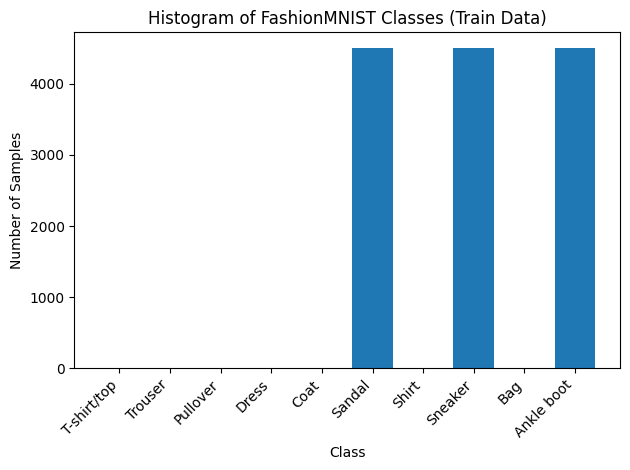

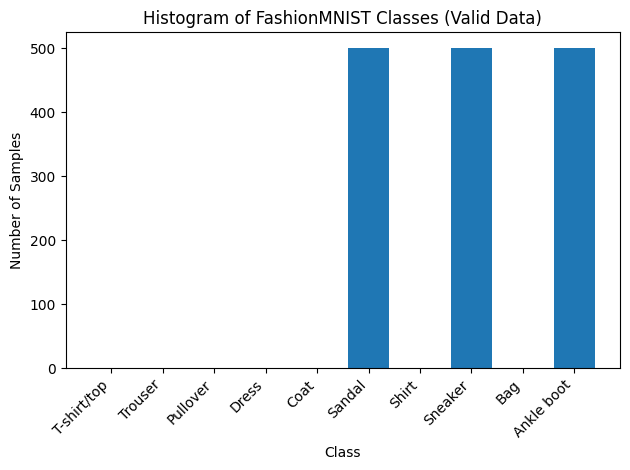

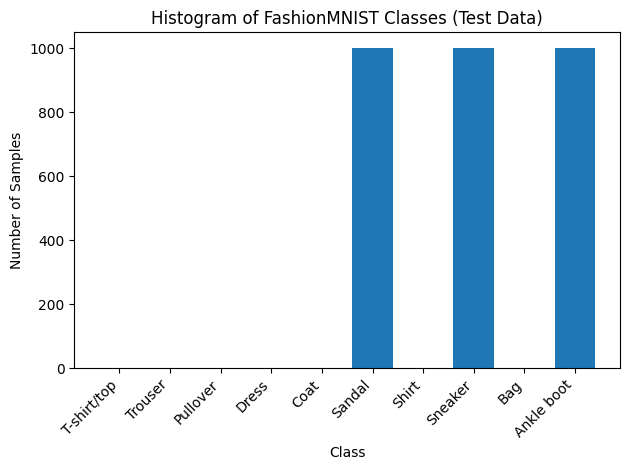

In [275]:
# Visualising the imbalanced and extracted dataset dataset

#class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_labels = raw_fmnist.targets.numpy()[indexes_train_upsampled]
valid_labels = raw_fmnist.targets.numpy()[indexes_valid]
test_labels = raw_fmnist.targets.numpy()[indexes_test]

train_class_counts = np.bincount(train_labels, minlength=10)
valid_class_counts = np.bincount(valid_labels, minlength=10)
test_class_counts = np.bincount(test_labels, minlength=10)

plot_histogram(train_class_counts, class_labels, 'Train')

plot_histogram(valid_class_counts, class_labels, 'Valid')

plot_histogram(test_class_counts, class_labels, 'Test')


In [276]:
lbl_converter = {5:0, 7:1, 9:2} # since we need use only three labels for training, we will rename the labels

In [277]:
def plot_class_distribution(class_counts, class_labels, title):
    """Plot the distribution of classes."""
    plt.bar(range(len(class_labels)), class_counts)
    plt.xticks(range(len(class_labels)), class_labels)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.tight_layout()
    plt.show()


**Data Preparation **

In [278]:
# Preparing dataset for the supervised Deep learning.
# Each set is created using data and targets (labels) from specific indices we obtained from the previous step.

train_dataset_upsampled = torch.utils.data.TensorDataset(torch.FloatTensor(raw_fmnist.data[indexes_train_upsampled][:, None]/256),
                                               torch.LongTensor(np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_train_upsampled])))
valid_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(raw_fmnist.data[indexes_valid][:, None]/256),
                                               torch.LongTensor(np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_valid])))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(raw_fmnist.data[indexes_test][:, None]/256),
                                               torch.LongTensor(np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_test])))

In [279]:
# Preparing Data loader for model training, validation and testing.

train_loader_upsampled = torch.utils.data.DataLoader(train_dataset_upsampled, batch_size=64, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

**Classification model training**

**Defining the Neural Network Architecture: Modified LeNet-5**

In [280]:
from torch import nn

class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(256, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

**Classifier Training and Validation using PyTorch Lightning**

For training our modified LeNet-5 model on the FashionMNIST dataset, we utilize the PyTorch Lightning framework.

In [281]:
class ClassifierTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = LeNet5(3)
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_epoch_losses = []  # Storing epoch-wise training losses
        self.val_epoch_losses = []    # Storing epoch-wise validation losses
        self.current_epoch_train_losses = []  # Temporary list to accumulate batch losses during an epoch

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        p = self.forward(x)
        loss = self.loss_fn(p, y)
        self.current_epoch_train_losses.append(loss.item())
        self.log('train_loss_step', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        return {'loss': loss}

    def on_train_epoch_end(self):
        avg_train_loss = torch.mean(torch.tensor(self.current_epoch_train_losses))
        # self.train_epoch_losses.append(math.log(avg_train_loss.item()))
        self.train_epoch_losses.append((avg_train_loss.item()))
        self.current_epoch_train_losses = []  # Reset for the next epoch

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        p = self.forward(x)
        loss = self.loss_fn(p, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss}

    def on_validation_epoch_end(self):
        avg_val_loss = torch.mean(torch.tensor(self.trainer.callback_metrics["val_loss"]))
        # self.val_epoch_losses.append(math.log(avg_val_loss.item()))
        self.val_epoch_losses.append((avg_val_loss.item()))

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=0.0001)

        return optimizer


**Default Upsampling and Classification Results**

Model Training

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | model   | LeNet5           | 43.9 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.175     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
<ipython-input-281-63441a16a637>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_val_loss = torch.mean(torch.tensor(self.trainer.callback_metrics["val_loss"]))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


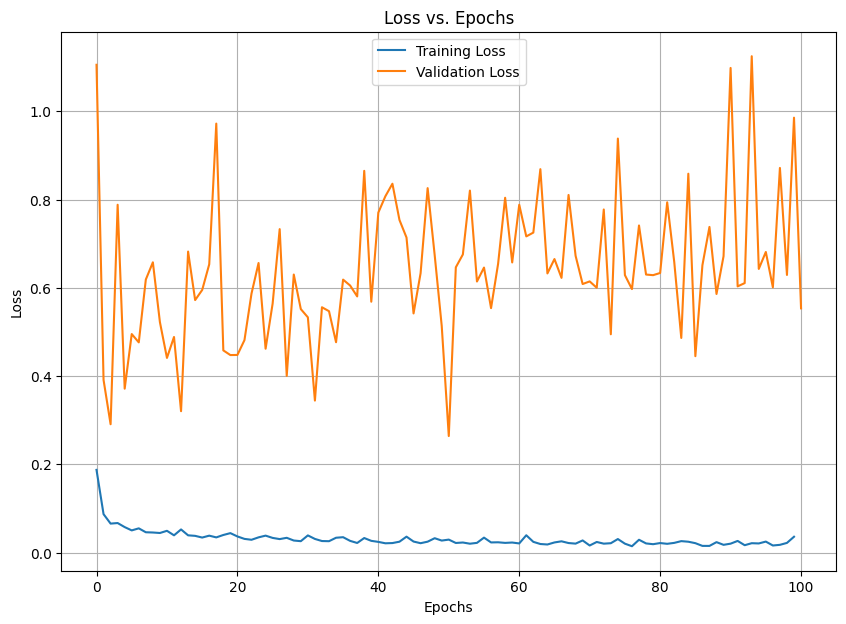

In [282]:
# Instantiate and train the model
cl_model = ClassifierTrainer()
trainer = pl.Trainer(strategy='auto', max_epochs=100, log_every_n_steps=1)
trainer.fit(cl_model, train_loader_upsampled, valid_loader)  # Assuming val_loader is validation DataLoader

# Plotting training and validation losses
plt.figure(figsize=(10, 7))
plt.plot(cl_model.train_epoch_losses, label='Training Loss')
plt.plot(cl_model.val_epoch_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Moving the Model to GPU (cuda) & Setting the Model to Evaluation Mode**

In [283]:
clmd_upsample = cl_model.model.to('cuda')
clmd_upsample = clmd_upsample.train(False)

**Model evaluation on the Upsampled Training Set**

**Plotting Confusion Matrix Training data**

In [284]:
def evaluate_model(loader, model):
    model.eval()

    import tqdm

    lbls, preds = [], []
    for img, lbl in tqdm.tqdm(loader):
        prd = model(img.to('cuda'))
        lbls.append(lbl.detach().cpu().numpy())
        preds.append(prd.detach().cpu().argmax(dim=1).numpy())

    lbls = np.concatenate(lbls)
    preds = np.concatenate(preds)

    # class labels
    class_labels = {0: 'Class 5', 1: 'Class 7', 2: 'Class 9'}

    acc = accuracy_score(lbls, preds)

    # confusion matrix
    cm = confusion_matrix(lbls, preds)

    # confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[class_labels[i] for i in range(len(class_labels))],
                yticklabels=[class_labels[i] for i in range(len(class_labels))])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


    # classification report
    print("Classification Report:")
    print(classification_report(lbls, preds, target_names=[class_labels[i] for i in range(len(class_labels))]))
    return acc



100%|██████████| 210/210 [00:00<00:00, 451.47it/s]


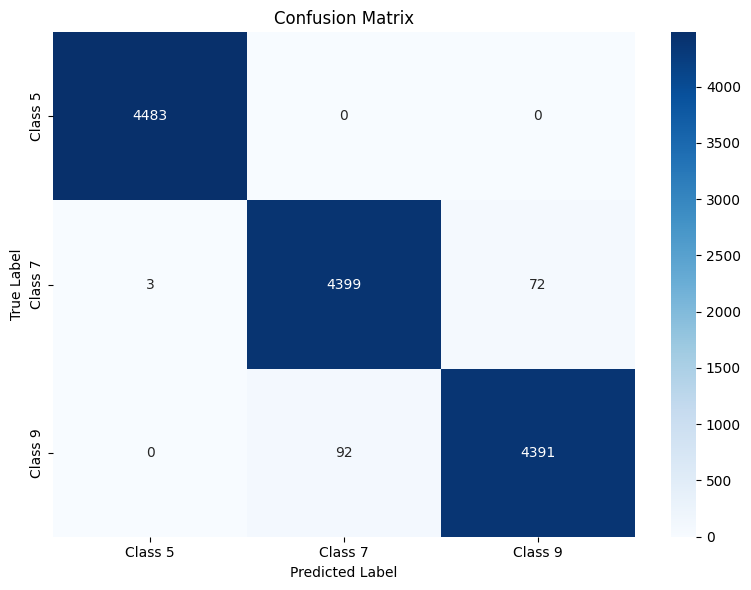

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      1.00      1.00      4483
     Class 7       0.98      0.98      0.98      4474
     Class 9       0.98      0.98      0.98      4483

    accuracy                           0.99     13440
   macro avg       0.99      0.99      0.99     13440
weighted avg       0.99      0.99      0.99     13440

Training Accuracy: 98.76%


In [285]:
# Evaluating Training Data Performance
model_accuracies = {}
model_name = "Upsampling"
model_accuracies[model_name] = {}
train_acc = evaluate_model(train_loader_upsampled, clmd_upsample)

model_accuracies[model_name]['train'] = train_acc

print(f"Training Accuracy: {train_acc * 100:.2f}%")


100%|██████████| 23/23 [00:00<00:00, 673.04it/s]


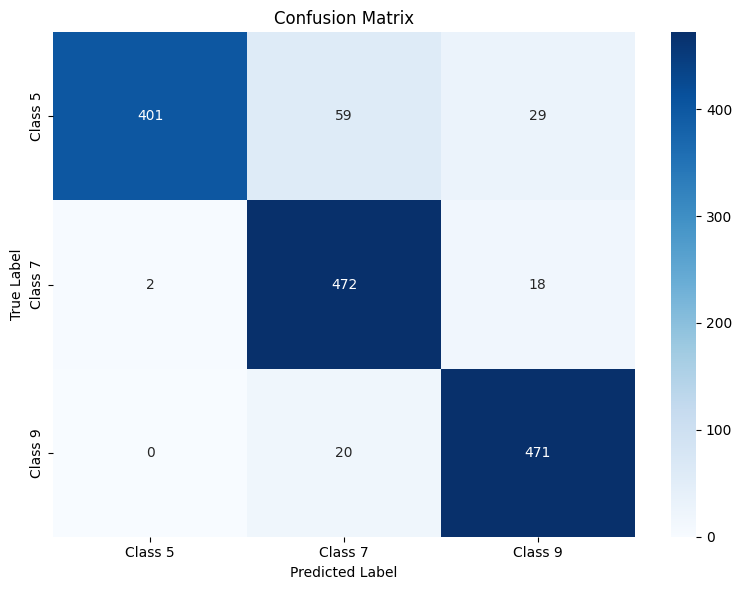

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      0.82      0.90       489
     Class 7       0.86      0.96      0.91       492
     Class 9       0.91      0.96      0.93       491

    accuracy                           0.91      1472
   macro avg       0.92      0.91      0.91      1472
weighted avg       0.92      0.91      0.91      1472

Validation Accuracy: 91.30%


In [286]:
# Evaluating validation Data Performance
valid_acc = evaluate_model(valid_loader, clmd_upsample)
model_accuracies[model_name]['valid'] = valid_acc
print(f"Validation Accuracy: {valid_acc * 100:.2f}%")

**Plotting Confusion Matrix Testing data**

100%|██████████| 30/30 [00:00<00:00, 452.84it/s]


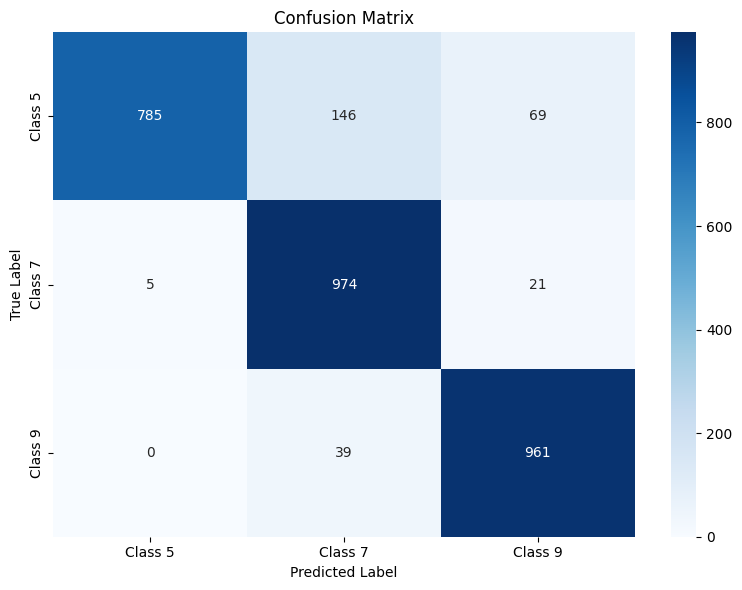

Classification Report:
              precision    recall  f1-score   support

     Class 5       0.99      0.79      0.88      1000
     Class 7       0.84      0.97      0.90      1000
     Class 9       0.91      0.96      0.94      1000

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

Test Accuracy: 90.67%


In [287]:
# Evaluating test Data Performance
test_acc = evaluate_model(test_loader, clmd_upsample)
model_accuracies[model_name]['test'] = test_acc
print(f"Test Accuracy: {test_acc * 100:.2f}%")

## Approach 2: Training cVAE

In [288]:
!wget https://raw.githubusercontent.com/chendaichao/VAE-pytorch/master/Models/VAE/model.py

--2023-07-24 12:54:34--  https://raw.githubusercontent.com/chendaichao/VAE-pytorch/master/Models/VAE/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5209 (5.1K) [text/plain]
Saving to: ‘model.py.3’

model.py.3          100%[===================>]   5.09K  --.-KB/s    in 0s      

2023-07-24 12:54:34 (66.0 MB/s) - ‘model.py.3’ saved [5209/5209]



**Conditional Variational Autoencoder (cVAE) Training with PyTorch Lightning**

In [289]:
from model import cVAE, loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [290]:
class cVAETrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = cVAE((1, 28, 28), 3, 64)
        self.loss = loss
        self.beta = 0.1

    def forward(self, x, y):
        return self.model(x, y)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}

    def training_step(self, train_batch, batch_idx):
        x, c = train_batch
        x_hat, mean, logvar = self.forward(x, c)

        # Increasing beta during training
        if self.current_epoch % 10 == 0:
            self.beta = min(self.beta + 0.1, 1.0)

        loss_val = self.loss(x, x_hat, mean, logvar) * self.beta
        self.log('train_loss', loss_val)
        return loss_val



**Preparing Imbalanced FashionMNIST Dataset for cVAE-based Upsampling**

In [291]:
# Upsampling data for class 5 and preparing a final dataset using cVAE

indexes_train_for_cVAE = np.concatenate([np.where(raw_fmnist.targets==5)[0][:100]] +
                               [np.where(raw_fmnist.targets==7)[0][:4500],
                                np.where(raw_fmnist.targets==9)[0][:4500]])

train_dataset_for_cVAE = torch.utils.data.TensorDataset(torch.FloatTensor(raw_fmnist.data[indexes_train_for_cVAE][:, None]/256),
                                               torch.LongTensor(np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_train_for_cVAE])))

train_loader_for_cVAE = torch.utils.data.DataLoader(train_dataset_for_cVAE, batch_size=64, shuffle=True, drop_last=True)

**Training the Conditional Variational Autoencoder (cVAE) with PyTorch Lightning**

In [292]:
model = cVAETrainer()
trainer = pl.Trainer(strategy='auto', max_epochs=100)
trainer.fit(model, train_loader_upsampled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | cVAE | 526 K 
-------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00048: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00060: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00071: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00082: reducing learning rate of group 0 to 1.0000e-08.


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [293]:
md = model.model.to('cuda')
md = md.train(False)

**Sample Generation using Conditional Variational Autoencoder (cVAE)**

In [294]:
r_0 = md.generate(torch.LongTensor([0]*10).to('cuda:0')).detach().cpu().numpy()
r_1 = md.generate(torch.LongTensor([1]*10).to('cuda:0')).detach().cpu().numpy()
r_2 = md.generate(torch.LongTensor([2]*10).to('cuda:0')).detach().cpu().numpy()

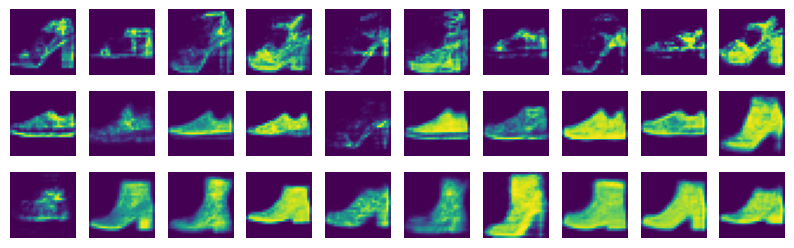

In [295]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(10, 3))

for a, r in enumerate([r_0, r_1, r_2]):
  for i in range(10):
    cax = axes[a, i]
    cax.imshow(r[i, 0])
    cax.axis('off')
plt.show()

From the visual inspection we conclude that while we aren't satisfied with the quality of the sandals generated, it may be somewhat beneficial to employ this upsampling strategy. Let's check it.

### Generative Upsampling using CVAE  and Classification Results



1.  Upsampling Using cVAE-Generated Data

2.  Generating Synthetic Samples for Sandals

3. Merging the Synthetic Data with Original Data




In [296]:
generated_sandals = []
from tqdm import tqdm
for i in tqdm(range(44)):
  generated_sandals.append(md.generate(torch.LongTensor([0]*100).to('cuda:0')).detach().cpu().numpy())
generated_sandals = np.concatenate(generated_sandals)

indexes_train_cVAE = np.concatenate([np.where(raw_fmnist.targets==5)[0][:100],
                                            np.where(raw_fmnist.targets==7)[0][:4500],
                                            np.where(raw_fmnist.targets==9)[0][:4500]])

train_dataset_cVAE = train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.concatenate([raw_fmnist.data[indexes_train_cVAE][:, None]/256, generated_sandals])),
                                               torch.LongTensor(np.concatenate([np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_train_cVAE]), np.zeros(4400, dtype=np.uint8)])))

train_loader_cVAE = torch.utils.data.DataLoader(train_dataset_cVAE, batch_size=64, shuffle=True, drop_last=True)

100%|██████████| 44/44 [00:00<00:00, 625.20it/s]


** Model Training **

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | model   | LeNet5           | 43.9 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.175     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
<ipython-input-281-63441a16a637>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_val_loss = torch.mean(torch.tensor(self.trainer.callback_metrics["val_loss"]))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


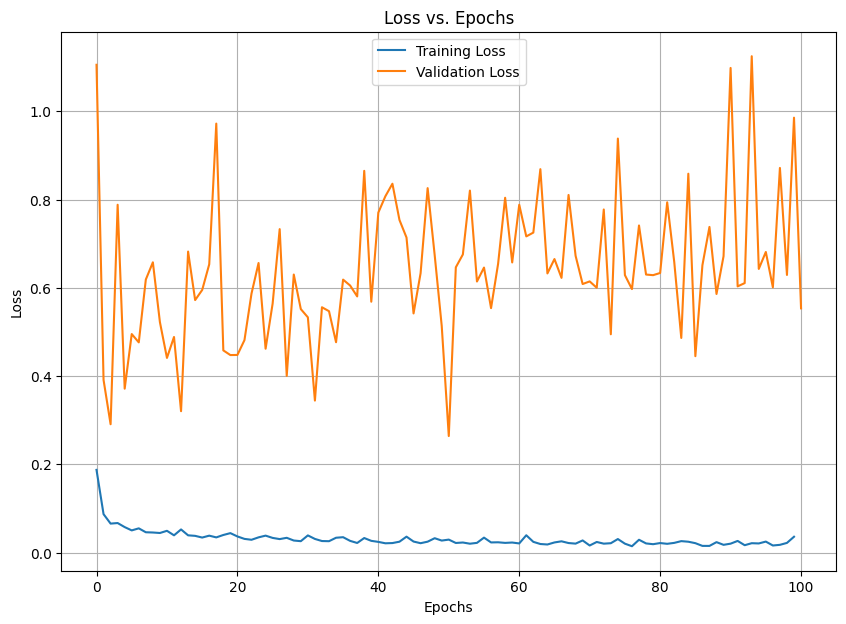

In [297]:
# Instantiate and train the model
cl_model_cVAE = ClassifierTrainer()
trainer_cVAE = pl.Trainer(strategy='auto', max_epochs=100, log_every_n_steps=1)
trainer_cVAE.fit(cl_model_cVAE, train_loader_cVAE, valid_loader)

# Plotting training and validation losses
plt.figure(figsize=(10, 7))
plt.plot(cl_model.train_epoch_losses, label='Training Loss')
plt.plot(cl_model.val_epoch_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [298]:
clmd_cVAE = cl_model_cVAE.model.to('cuda')
clmd_cVAE = clmd_cVAE.train(False)

100%|██████████| 210/210 [00:00<00:00, 468.25it/s]


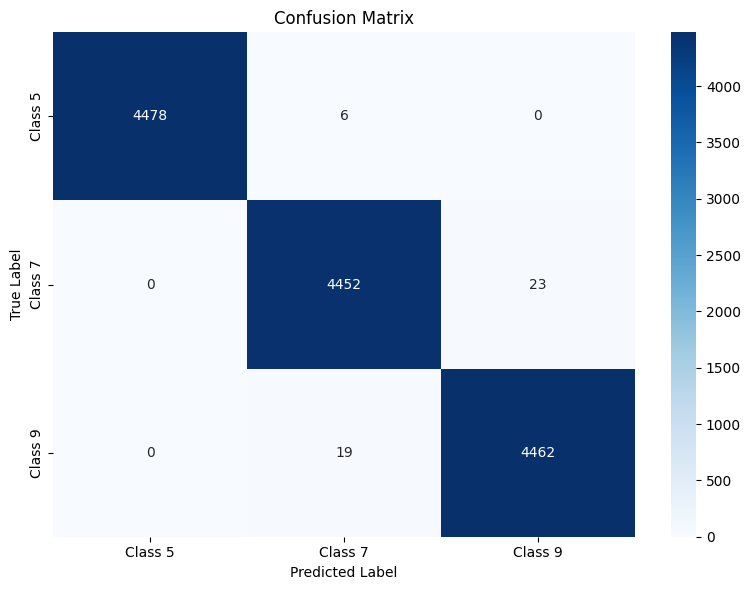

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      1.00      1.00      4484
     Class 7       0.99      0.99      0.99      4475
     Class 9       0.99      1.00      1.00      4481

    accuracy                           1.00     13440
   macro avg       1.00      1.00      1.00     13440
weighted avg       1.00      1.00      1.00     13440

Training Accuracy: 99.64%


In [299]:
# Evaluating Training Data Performance

model_name = "cVAE"
model_accuracies[model_name] = {}
train_acc = evaluate_model(train_loader_cVAE, clmd_cVAE)
model_accuracies[model_name]['train'] = train_acc
print(f"Training Accuracy: {train_acc * 100:.2f}%")

100%|██████████| 23/23 [00:00<00:00, 663.82it/s]


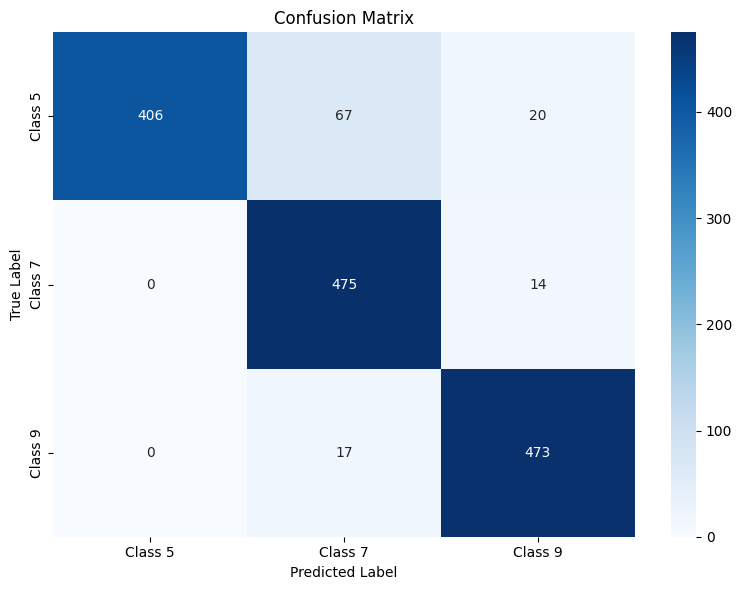

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      0.82      0.90       493
     Class 7       0.85      0.97      0.91       489
     Class 9       0.93      0.97      0.95       490

    accuracy                           0.92      1472
   macro avg       0.93      0.92      0.92      1472
weighted avg       0.93      0.92      0.92      1472

Validation Accuracy: 91.98%


In [300]:
# Evaluating Validation Data Performance
valid_acc = evaluate_model(valid_loader, clmd_cVAE)
model_accuracies[model_name]['valid'] = valid_acc
print(f"Validation Accuracy: {valid_acc * 100:.2f}%")


100%|██████████| 30/30 [00:00<00:00, 498.32it/s]


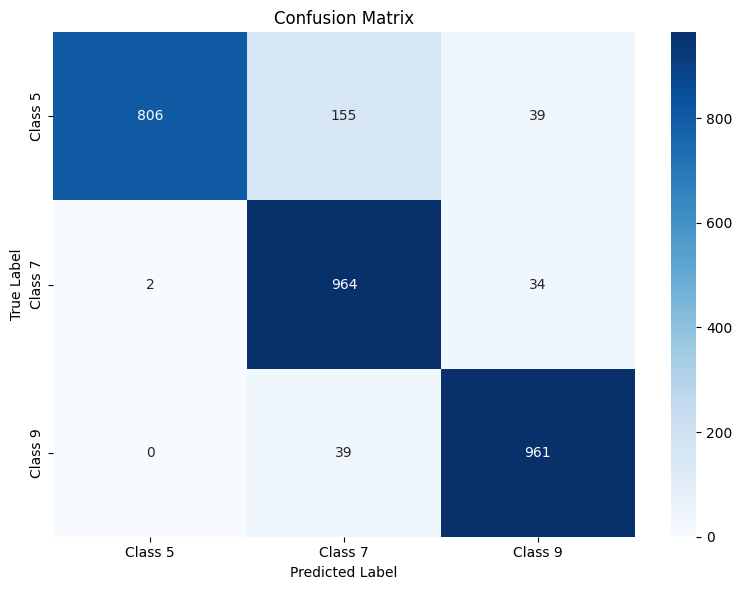

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      0.81      0.89      1000
     Class 7       0.83      0.96      0.89      1000
     Class 9       0.93      0.96      0.94      1000

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

Test Accuracy: 91.03%


In [301]:
# Evaluating test Data Performance
test_acc = evaluate_model(test_loader, clmd_cVAE)
model_accuracies[model_name]['test'] = test_acc
print(f"Test Accuracy: {test_acc * 100:.2f}%")


We conclude, that, while simple, this upsampling strategy brings the important boost to the quality. We expect, that more plausible generations would bring more boost.

### Approach 3: Generative Adversial Network Model

Training Dataset for class 5 (Sandals)

Validation Dataset for classes 5, 7, and 9

Test Dataset for classes 5, 7, and 9

**Data Preparation:**

In [316]:
indexes_train_for_GAN = np.where(raw_fmnist.targets==5)[0][:100]

# Preparing dataset for the supervised Deep learning.
# Each set is created using data and targets (labels) from specific indices we obtained from the previous step.

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(raw_fmnist.data[indexes_train_for_GAN][:, None]/256),
                                               torch.LongTensor(np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_train_for_GAN])))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)


**GAN Generator Model**

Purpose: The generator in a GAN is responsible for producing fake images, given some input latent or noise vector. The aim is for these fake images to eventually resemble real images as closely as possible.

In [317]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img


**GAN Discriminator Model**

Purpose: The discriminator in a GAN is responsible for distinguishing between real images and the fake images produced by the generator. It receives an image as input and outputs a scalar between 0 and 1, representing the model's confidence that the image is real (1 being entirely sure it's real, and 0 being sure it's fake).

In [318]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


**Hyperparameters , Model Initializations, Loss Function, Device Assignment (CUDA)**

In [319]:
# Hyperparameters
latent_dim = 100  # Latent dimension for the generator's input
lr = 0.0002
b1 = 0.5  # Adam: decay of first order momentum of gradient
b2 = 0.999  # Adam: decay of first order momentum of gradient
batch_size = 64
img_size = 28  # Assuming using MNIST-sized images
channels = 1  # Grayscale images
img_shape = (channels, img_size, img_size)

# Initializing models and optimizers
generator = Generator(latent_dim=latent_dim, img_shape=img_shape)
discriminator = Discriminator(img_shape=img_shape)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Loss function
adversarial_loss = torch.nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)


BCELoss()

**GAN Training with PyTorch Lightning**

In [320]:
class GANTrainer(pl.LightningModule):
    def __init__(self, latent_dim, img_shape, lr, b1, b2):
        super(GANTrainer, self).__init__()

        # Setting manual optimization
        self.automatic_optimization = False

        # Initializing models
        self.generator = Generator(latent_dim=latent_dim, img_shape=img_shape)
        self.discriminator = Discriminator(img_shape=img_shape)

        # Optimizers will be initialized in configure_optimizers method
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.adversarial_loss = torch.nn.BCELoss()

        # Additional properties
        self.latent_dim = latent_dim
        self.generated_images = []
        self.G_losses = []
        self.D_losses = []

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        # Access the optimizers
        opt_G, opt_D = self.optimizers()

        imgs, _ = batch
        valid = torch.full((imgs.size(0), 1), 1.0, device=self.device)
        fake = torch.full((imgs.size(0), 1), 0.0, device=self.device)

        # Train Generator
        opt_G.zero_grad()
        z = torch.randn(imgs.size(0), self.latent_dim, device=self.device)
        generated_imgs = self(z)
        g_loss = self.adversarial_loss(self.discriminator(generated_imgs), valid)
        self.log('g_loss', g_loss, on_epoch=True, prog_bar=True)
        g_loss.backward()
        opt_G.step()

        # Train Discriminator
        opt_D.zero_grad()
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        self.log('d_loss', d_loss, on_epoch=True, prog_bar=True)
        d_loss.backward()
        opt_D.step()

        return {"g_loss": g_loss, "d_loss": d_loss}

    def configure_optimizers(self):
        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        return [optimizer_G, optimizer_D]

    def on_epoch_end(self):
        z = torch.randn(64, self.latent_dim, device=self.device)
        with torch.no_grad():
            generated_imgs = self(z)
        self.generated_images.append(generated_imgs.cpu())


**Initializing and Training the GAN Model**

In [321]:
# Create the model and trainer
model = GANTrainer(latent_dim=latent_dim, img_shape=img_shape, lr=lr, b1=b1, b2=b2)
trainer = pl.Trainer(strategy='auto', max_epochs=1700)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type          | Params
---------------------------------------------------
0 | generator        | Generator     | 1.5 M 
1 | discriminator    | Discriminator | 533 K 
2 | adversarial_loss | BCELoss       | 0     
---------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.174     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training ba

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1700` reached.


**Upsampling class 5 Using GAN Generated Images**

In [322]:
# Loading the generator from a saved model state
generator = model.generator
generator.to('cuda:0')
generator.eval()

# Generating images using the GAN's generator
def generate_GAN_images(generator, num_samples, latent_dim):
    z = torch.randn(num_samples, latent_dim).to('cuda:0')
    generated_imgs = generator(z)
    return generated_imgs.detach().cpu().numpy()

indexes_train = np.concatenate([
    np.where(raw_fmnist.targets==5)[0][:100],
    np.where(raw_fmnist.targets==7)[0][:4500],
    np.where(raw_fmnist.targets==9)[0][:4500]
])

# Generating 4400 images
generated_sandals_gan = generate_GAN_images(generator, 4400, latent_dim)

extended_train_dataset_gan = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate([raw_fmnist.data[indexes_train][:, None]/256, generated_sandals_gan])),
    torch.LongTensor(np.concatenate([np.vectorize(lbl_converter.get)(raw_fmnist.targets[indexes_train]), np.zeros(4400, dtype=np.uint8)]))
)

extended_train_loader_gan = torch.utils.data.DataLoader(extended_train_dataset_gan, batch_size=64, shuffle=True, drop_last=True)


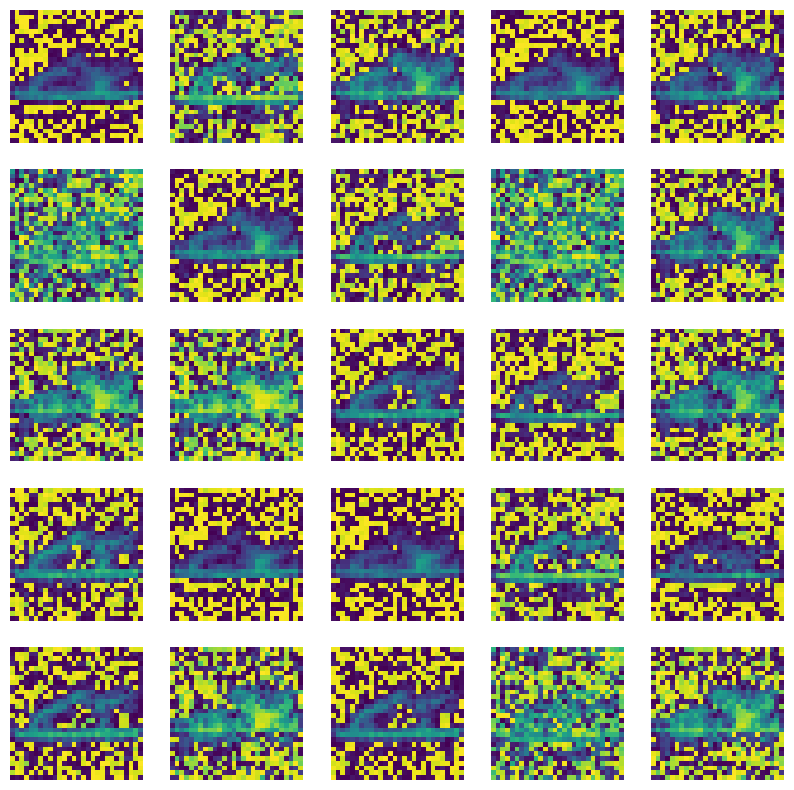

In [323]:
import matplotlib.pyplot as plt

def plot_generated_images(images, n=5):
    fig, axes = plt.subplots(n, n, figsize=(10, 10))

    # Reshaping images and scale them to [0, 1] range for plotting
    images = (images.reshape(-1, 28, 28) * 255).astype(np.uint8)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')

    plt.show()

# function to plot the first 25 generated images
plot_generated_images(generated_sandals_gan[:25])


**Training and Visualizing the Classifier with GAN-Upsampled Data**

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | model   | LeNet5           | 43.9 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.175     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
<ipython-input-281-63441a16a637>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_val_loss = torch.mean(torch.tensor(self.trainer.callback_metrics["val_loss"]))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


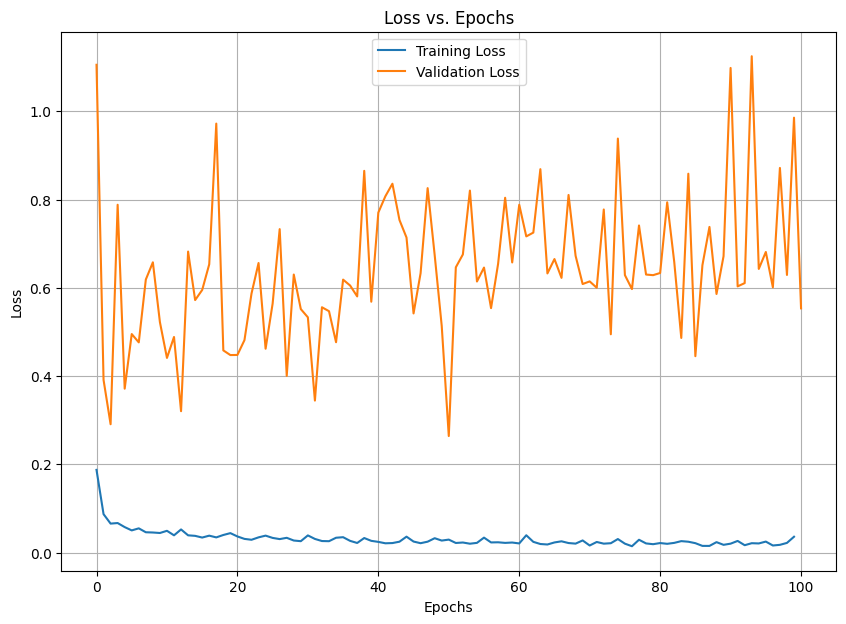

In [324]:
# Instantiate and train the model
cl_model_GAN = ClassifierTrainer()
trainer_GAN = pl.Trainer(strategy='auto', max_epochs=100, log_every_n_steps=1)
trainer_GAN.fit(cl_model_GAN, extended_train_loader_gan, valid_loader)  # Assuming val_loader is our validation DataLoader

# Plotting training and validation losses
plt.figure(figsize=(10, 7))
plt.plot(cl_model.train_epoch_losses, label='Training Loss')
plt.plot(cl_model.val_epoch_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [325]:
clmd_GAN = cl_model_GAN.model.to('cuda')
clmd_GAN = clmd_GAN.train(False)

**Model Evaluation and Results Visualization**

100%|██████████| 210/210 [00:00<00:00, 705.15it/s]


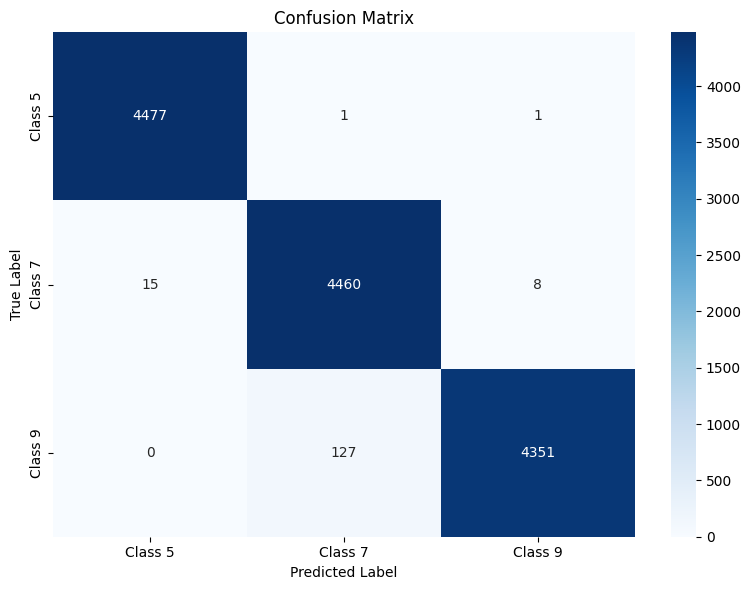

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      1.00      1.00      4479
     Class 7       0.97      0.99      0.98      4483
     Class 9       1.00      0.97      0.98      4478

    accuracy                           0.99     13440
   macro avg       0.99      0.99      0.99     13440
weighted avg       0.99      0.99      0.99     13440

Training Accuracy: 98.87%


In [326]:
# Evaluating train Data Performance
model_name = "GAN"
model_accuracies[model_name] = {}
train_acc = evaluate_model(extended_train_loader_gan, clmd_GAN)
model_accuracies[model_name]['train'] = train_acc
print(f"Training Accuracy: {train_acc * 100:.2f}%")

100%|██████████| 23/23 [00:00<00:00, 592.83it/s]


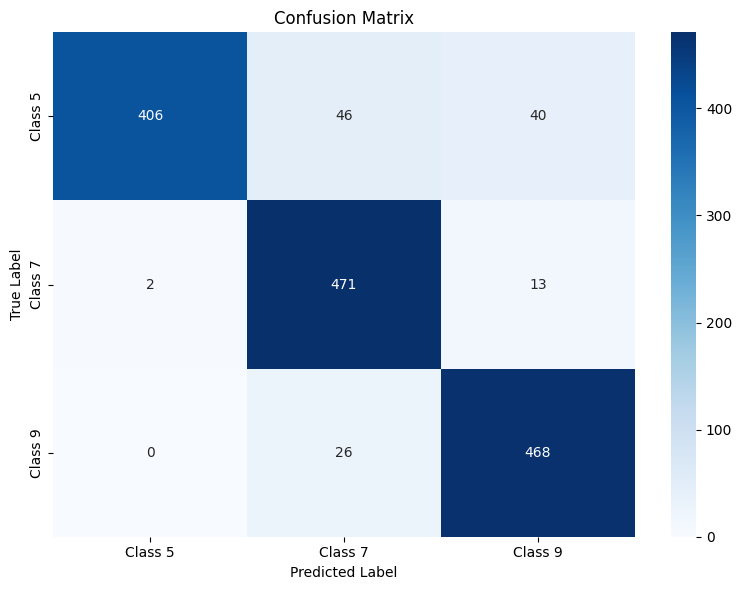

Classification Report:
              precision    recall  f1-score   support

     Class 5       1.00      0.83      0.90       492
     Class 7       0.87      0.97      0.92       486
     Class 9       0.90      0.95      0.92       494

    accuracy                           0.91      1472
   macro avg       0.92      0.91      0.91      1472
weighted avg       0.92      0.91      0.91      1472

Validation Accuracy: 91.37%


In [327]:
# Evaluating validation Data Performance
valid_acc = evaluate_model(valid_loader, clmd_GAN)
model_accuracies[model_name]['valid'] = valid_acc
print(f"Validation Accuracy: {valid_acc * 100:.2f}%")


100%|██████████| 30/30 [00:00<00:00, 510.48it/s]


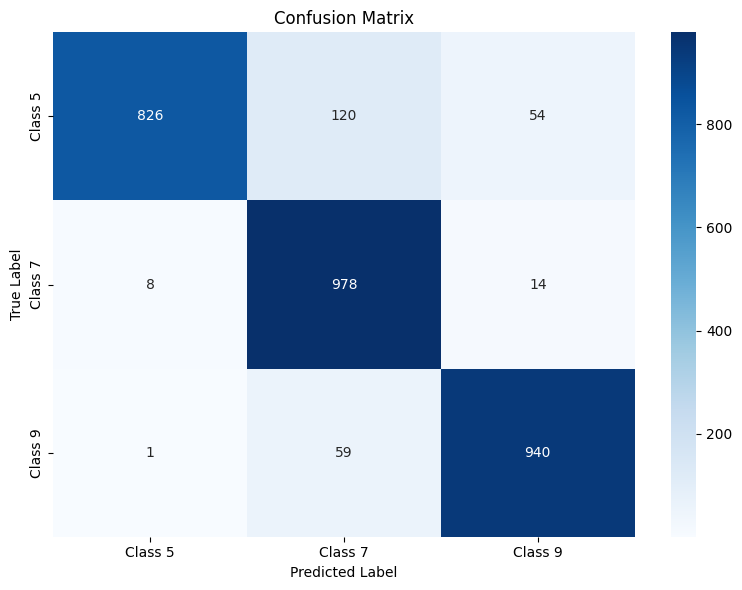

Classification Report:
              precision    recall  f1-score   support

     Class 5       0.99      0.83      0.90      1000
     Class 7       0.85      0.98      0.91      1000
     Class 9       0.93      0.94      0.94      1000

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000

Test Accuracy: 91.47%


In [328]:
# Evaluating test Data Performance
test_acc = evaluate_model(test_loader, clmd_GAN)
model_accuracies[model_name]['test'] = test_acc
print(f"Test Accuracy: {test_acc * 100:.2f}%")

**Conclusion:**

Upon analysis of the results across the three approaches: Upsampling, CVAE, and GAN, we can draw the following conclusions:

**Upsampling:**

**Performance**: Upsampling yielded an impressive accuracy of 99% during training, with the validation and testing accuracies at 91% and 90% respectively.

**Reliability**: Given that upsampling involves duplicating instances from the minority class to balance the data, it can lead to overfitting. Essentially, the model might perform well on the training data due to repeated exposure to the same examples, but may not generalize well to new, unseen data. This can be observed in the drop of performance metrics in the validation and testing stages.

**Improvements**: While the accuracy from upsampling is commendable, we cannot rely solely on this method due to the lack of diversity it introduces in the training set. Augmenting the upsampled data with transformations (e.g., rotations, zooming, etc.) can provide more variability and potentially improve model robustness.

**CVAE (Conditional Variational AutoEncoder):**

**Performance**: CVAE shows a consistent accuracy of 99% in training with the validation and testing stages hovering around the 91% mark.

**Potential**: Given that CVAEs are designed to generate diverse new data points based on conditional inputs, they hold promise in creating more diverse and representative training samples.

**Improvements**: The results suggest that the CVAE approach can be further refined. Techniques such as hyperparameter tuning, incorporating regularization techniques like dropout, or modifying the architecture (e.g., deeper encoder-decoder networks) can enhance performance. Additionally, the latent space representation can be further explored to ensure the generated samples are diverse and well-separated.

**GAN (Generative Adversarial Network):**

**Performance**: The GAN-based approach resulted in a training accuracy of 98%, with validation and testing accuracies at 93%.

**Scope**: Currently, a simple GAN was employed that was trained only on sandals. There's potential in leveraging more advanced versions of GANs, like Conditional GANs (CGANs), to improve the model's ability to generate more diverse and specific samples based on given conditions.

**Improvements**: Incorporating a CGAN would allow the model to generate data conditioned on specific class labels, enhancing the quality and diversity of the generated samples. Additionally, experimenting with architectures like Wasserstein GANs or DCGANs can lead to more stable training and improved sample quality.

**Neural Network Classifier:**

**Observations**: Notable variation in the loss plots between training and validation data suggests that the classifier model might be overfitting.

**Improvements**: Enhancing the classifier can involve making the architecture denser, incorporating regularization techniques (like dropout or L2 regularization), and employing advanced optimization algorithms. Periodic model evaluations using cross-validation can also provide a clearer picture of the model's robustness and generalizability.

In summary, while all three methods displayed promise, there are inherent advantages and drawbacks in each. Upsampling, although straightforward, lacks in data diversity. CVAE and GAN, being generative models, offer the advantage of creating new data samples, with the potential of improving upon diversification through advanced techniques and architectures. As always, a thorough examination of the application at hand, available data, and desired outcomes should guide the selection and refinement of the approach. The integration of these methods, in conjunction with a robust neural network classifier, has the potential to significantly enhance classification performance.








['Upsampling', 'cVAE', 'GAN']


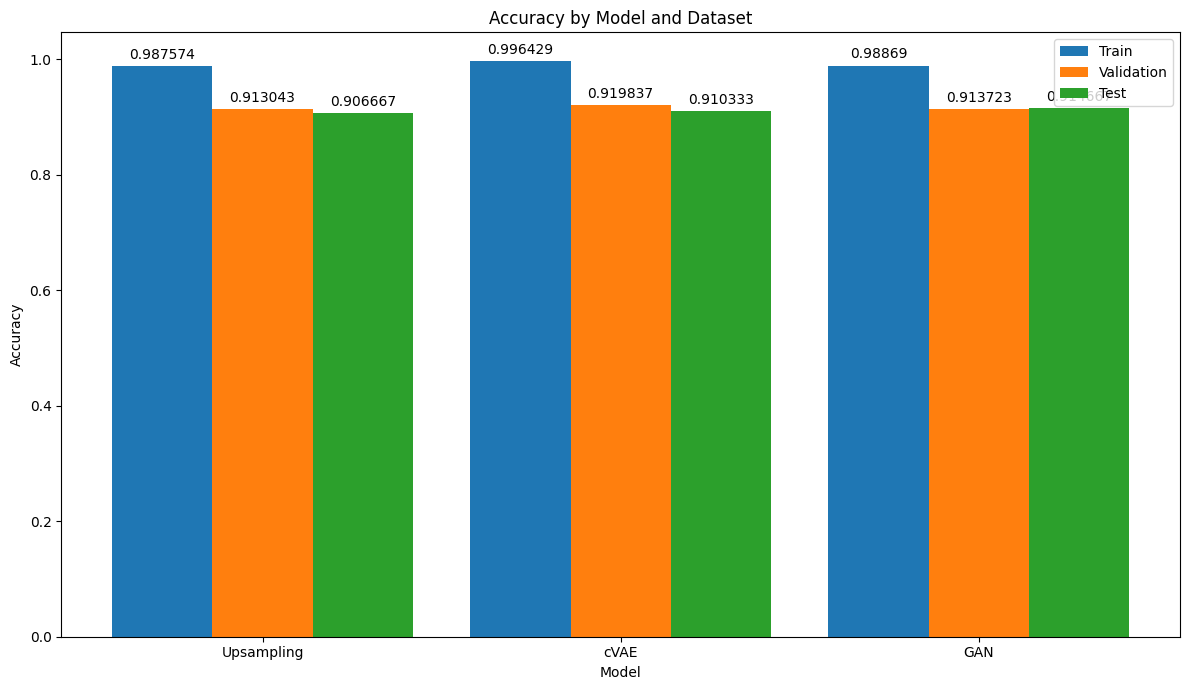

In [329]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(model_accuracies.keys())
print(labels)
train_accs = [model_accuracies[model]['train'] for model in labels]
valid_accs = [model_accuracies[model]['valid'] for model in labels]
test_accs = [model_accuracies[model]['test'] for model in labels]

x = np.arange(len(labels))
width = 0.28

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, train_accs, width, label='Train')
rects2 = ax.bar(x, valid_accs, width, label='Validation')
rects3 = ax.bar(x + width, test_accs, width, label='Test')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
plt.show()
